# Zillow Time Series Analysis

## Business Problem

If a real estate company is looking to flip homes, what are the top 5 zip codes to invest in? How will we scale our data? What defines best?

For this dataset, we will only include data from New Jersey. Because of the housing market crash and Hurricane Sandy, any modelling that uses only recent years may be misleading. We will use every value from 1996 to 2018 so we can the most accurate picture of home values in NJ through the years. To define best, we will take the home values from the beginning and the end of the dataset to calculate the total ROI. Then, through our time series analysis, we will find the 5 zip codes with the best outlooks.

## Step 1: Load the Data/Filter for Chosen Zipcodes

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from scipy import stats
from random import gauss as gs
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE, r2_score
from math import sqrt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from pmdarima import auto_arima
from matplotlib.pylab import rcParams
%matplotlib inline
plt.style.use('ggplot')

#Import dataset
df = pd.read_csv('data/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Step 2: Data Preprocessing

In this dataset, RegionName appears to mean Zip Code.

In [2]:
#Rename RegionName
df.rename({'RegionName': 'ZipCode'}, axis='columns', inplace=True)

For this project, we will only be looking at the zip codes in New Jersey so we can drop the rest.

In [3]:
#Delete all but NJ zipcodes
df_nj = df.loc[df['State']== 'NJ'].reset_index()
df_nj.drop(['index', 'RegionID', 'SizeRank'], axis=1, inplace=True)
print('Total Zipcodes in DataFrame:', len(df_nj))

Total Zipcodes in DataFrame: 502


In [4]:
#Check for zeros
df_nj.describe()

,ZipCode,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,502.000000,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,...,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02
mean,7904.276892,1.752159e+05,1.751141e+05,1.749928e+05,1.748564e+05,1.747329e+05,1.746448e+05,1.746343e+05,1.746733e+05,1.748956e+05,...,3.826530e+05,3.849859e+05,3.872106e+05,3.891757e+05,3.906855e+05,3.922143e+05,3.941520e+05,3.961333e+05,3.979994e+05,3.990378e+05
std,576.805651,8.737393e+04,8.739829e+04,8.742604e+04,8.744812e+04,8.747476e+04,8.751358e+04,8.758072e+04,8.766951e+04,8.784892e+04,...,2.630269e+05,2.651612e+05,2.677705e+05,2.698981e+05,2.702015e+05,2.701993e+05,2.712361e+05,2.715407e+05,2.706710e+05,2.699008e+05
min,7001.000000,5.140000e+04,5.120000e+04,5.090000e+04,5.060000e+04,5.030000e+04,5.010000e+04,4.980000e+04,4.950000e+04,4.930000e+04,...,3.780000e+04,3.840000e+04,3.910000e+04,3.970000e+04,4.010000e+04,4.090000e+04,4.140000e+04,4.210000e+04,4.400000e+04,4.590000e+04
25%,7460.250000,1.196500e+05,1.195750e+05,1.195000e+05,1.194000e+05,1.193000e+05,1.192250e+05,1.191500e+05,1.193000e+05,1.198250e+05,...,2.221750e+05,2.247250e+05,2.265250e+05,2.295250e+05,2.313000e+05,2.333750e+05,2.358000e+05,2.385750e+05,2.389250e+05,2.402000e+05
50%,7875.000000,1.566500e+05,1.566500e+05,1.566000e+05,1.565500e+05,1.564500e+05,1.563500e+05,1.559500e+05,1.555500e+05,1.551500e+05,...,3.196500e+05,3.233500e+05,3.242000e+05,3.269500e+05,3.290500e+05,3.316500e+05,3.330500e+05,3.341000e+05,3.350000e+05,3.365500e+05
75%,8317.750000,2.060750e+05,2.061000e+05,2.059000e+05,2.054750e+05,2.049750e+05,2.049000e+05,2.055000e+05,2.054750e+05,2.063500e+05,...,4.618250e+05,4.649500e+05,4.663750e+05,4.676250e+05,4.709000e+05,4.726250e+05,4.723500e+05,4.730500e+05,4.747250e+05,4.741500e+05
max,8904.000000,1.075400e+06,1.075900e+06,1.076500e+06,1.077100e+06,1.077700e+06,1.078400e+06,1.079200e+06,1.080000e+06,1.081200e+06,...,2.902500e+06,2.959000e+06,3.035000e+06,3.092700e+06,3.077500e+06,3.047100e+06,3.054800e+06,3.061200e+06,3.060700e+06,3.069100e+06


Now, we will create a time series by changing the data from wide view to long view, and indexing it by the Date.

In [5]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State', 'Metro', 'CountyName'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [6]:
melted_df = melt_data(df_nj)

We will also want to make sure we change zip code into a string so it is not confused for an integer.

In [7]:
#Change Zipcode dtype to 'str'
melted_df['ZipCode'] = melted_df['ZipCode'].astype(str)

# Make sure the data type of the 'Date' column is datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%m/%y')

# Set the 'Date' column as index
melted_df.set_index('Date', inplace=True)

In [8]:
melted_df.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=133030, freq=None)

In [9]:
melted_df.info()
melted_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133030 entries, 1996-04-01 to 2018-04-01
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ZipCode     133030 non-null  object 
 1   City        133030 non-null  object 
 2   State       133030 non-null  object 
 3   Metro       133030 non-null  object 
 4   CountyName  133030 non-null  object 
 5   value       133030 non-null  float64
dtypes: float64(1), object(5)
memory usage: 7.1+ MB


,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,7030,Hoboken,NJ,New York,Hudson,301600.0
1996-04-01,8701,Lakewood,NJ,New York,Ocean,153800.0
1996-04-01,8753,Toms River,NJ,New York,Ocean,123400.0
1996-04-01,7002,Bayonne,NJ,New York,Hudson,145000.0
1996-04-01,7302,Jersey City,NJ,New York,Hudson,137200.0


In [10]:
melted_df.tail()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
2018-04-01,8319,Estell Manor,NJ,Atlantic City,Atlantic,188800.0
2018-04-01,8006,Barnegat Light,NJ,New York,Ocean,795200.0
2018-04-01,8328,Franklin,NJ,Philadelphia,Gloucester,161300.0
2018-04-01,8317,Weymouth,NJ,Atlantic City,Atlantic,165000.0
2018-04-01,8241,Port Republic,NJ,Atlantic City,Atlantic,179300.0


## Step 3: Exploratory Data Analysis

Next, we will create some graphs to get a better idea of the data we are working with. We will also select zip codes that should be considered for our model.

In [11]:
metro = melted_df.groupby('Metro')
metro = metro.value.mean()
metro = metro.sort_values(ascending=False).head()

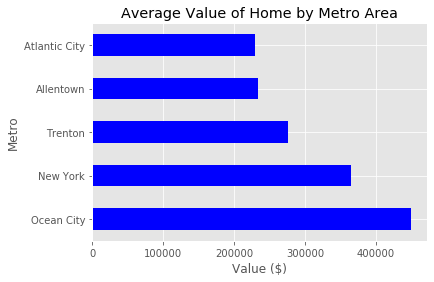

In [12]:
metro.plot.barh(color='blue')
plt.title('Average Value of Home by Metro Area')
plt.xlabel('Value ($)')
plt.show()

Here we get a good idea of the average home value per Metro area.

In [13]:
print('Average NJ home value' ,round(melted_df['value'].mean(), 2))

Average NJ home value 325240.62


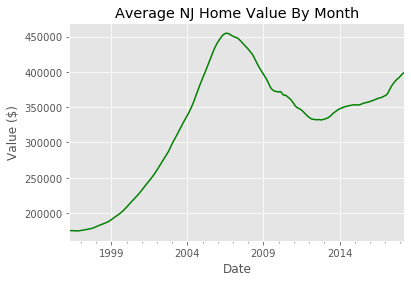

In [14]:
monthly_data = melted_df.resample('MS').mean()['value']
monthly_data.plot(color='green')
plt.title('Average NJ Home Value By Month')
plt.ylabel('Value ($)')
plt.show()

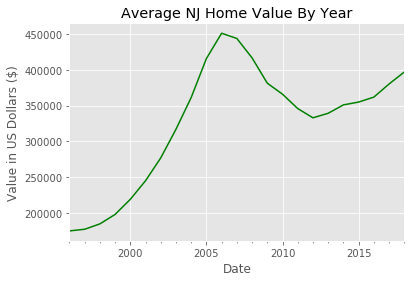

In [15]:
yearly_data = melted_df['value'].resample(rule='A').mean()
yearly_data.plot.line(color='green')
plt.title('Average NJ Home Value By Year')
plt.ylabel('Value in US Dollars ($)')
plt.savefig('images/njhomevalue.png', dpi=300)
plt.show()

The monthly and yearly home values seem ot be similar.

Next, we will cut down on variation to ensure we get the true most valuable zip codes.

In [16]:
df_nj['yr_avg']=df_nj.iloc[:,-12:].mean(skipna=True, axis=1)

#Get zipcodes with an average value 1 decile above the median and 1.5 deciles below.
print(df_nj['yr_avg'].describe(),'\n')

#Calculate the 70% cutoff value (1 decile above).
q_70 = df_nj['yr_avg'].quantile(q=0.70)
print(f'Average Value 70% cutoff value: {round(q_70,2)}')

#Calculate the 30% cutoff value (1.5 deciles below).
q_30 = df_nj['yr_avg'].quantile(q=0.30)
print(f'Average Value 30% cutoff value: {round(q_30,2)}')

#Get data frame with selected zipcodes.
df_avg = df_nj[(df_nj['yr_avg']<q_70) & (df_nj['yr_avg']>q_30)]
print(f'Amount of zipcodes: {len(df_avg)}')

count    5.020000e+02
mean     3.892963e+05
std      2.674433e+05
min      4.043333e+04
25%      2.293875e+05
50%      3.271542e+05
75%      4.724229e+05
max      3.013675e+06
Name: yr_avg, dtype: float64 

Average Value 70% cutoff value: 436960.0
Average Value 30% cutoff value: 250551.67
Amount of zipcodes: 200


In [17]:
#Calculate historical return on investment
df_avg['ROI'] = (df_avg['2018-04']/df_avg['1996-04'])-1

#Calculate standard deviation of monthly values
df_avg['std'] = df_avg.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df_avg['mean'] = df_avg.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variation
df_avg['CV'] = df_avg['std']/df_avg['mean']

#Show calculated values
df_avg[['ZipCode','std','mean','ROI','CV']].head()

,ZipCode,std,mean,ROI,CV
1,8701,78323.563147,284704.905660,1.670351,0.275104
2,8753,65597.121349,226923.396226,1.141815,0.289072
3,7002,83193.511970,269655.471698,1.571724,0.308518
5,7093,108841.412393,291018.867925,2.133637,0.374001
6,8831,76721.781086,364016.603774,0.997712,0.210765


Now that we have cut down on variation of home values, let's select the top 12 that we will model.

In [18]:
#Descriptive statistics of coefficients of variance.
print(df_avg.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df_avg.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 15 zipcodes with highest ROIs within the firms risk profile.
df_top12 = df_avg[df_avg['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:12]

#print('\n Top 12 Zipcodes:')
df_top12[['ZipCode','ROI','CV']]

count    200.000000
mean       0.260842
std        0.035173
min        0.197158
25%        0.237903
50%        0.256344
75%        0.272784
max        0.402980
Name: CV, dtype: float64

CV upper limit: 0.2623167767046959


,ZipCode,ROI,CV
286,7075,1.376684,0.256951
72,7747,1.344889,0.260248
199,7066,1.339286,0.246989
12,8527,1.327152,0.256716
116,7724,1.307865,0.251599
376,8230,1.306785,0.255422
61,7731,1.298211,0.262275
105,7748,1.288782,0.250705
73,7410,1.283657,0.251255
257,8824,1.279893,0.247093


In [19]:
#Get city and state names for each zip code
top12_zip = list(df_top12.ZipCode.values)
for i in top12_zip:
    City = df_nj[df_nj['ZipCode']==i].City.values[0]
    Metro = df_nj[df_nj['ZipCode']==i].Metro.values[0]
    CountyName = df_nj[df_nj['ZipCode']==i].CountyName.values[0]
    print(f'Zip Code : {i} \nCity: {City}, County: {CountyName}, Metro: {Metro}\n')

Zip Code : 7075 
City: Wood Ridge, County: Bergen, Metro: New York

Zip Code : 7747 
City: Matawan, County: Monmouth, Metro: New York

Zip Code : 7066 
City: Clark, County: Union, Metro: New York

Zip Code : 8527 
City: Jackson, County: Ocean, Metro: New York

Zip Code : 7724 
City: Tinton Falls, County: Monmouth, Metro: New York

Zip Code : 8230 
City: Upper, County: Cape May, Metro: Ocean City

Zip Code : 7731 
City: Howell, County: Monmouth, Metro: New York

Zip Code : 7748 
City: Middletown, County: Monmouth, Metro: New York

Zip Code : 7410 
City: Fair Lawn, County: Bergen, Metro: New York

Zip Code : 8824 
City: South Brunswick, County: Middlesex, Metro: New York

Zip Code : 7604 
City: Hasbrouck Heights, County: Bergen, Metro: New York

Zip Code : 7621 
City: Bergenfield, County: Bergen, Metro: New York



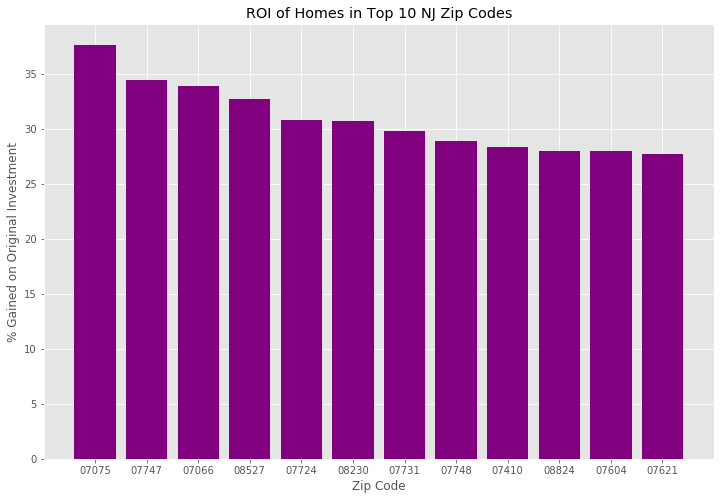

In [20]:
x = ['07075', '07747', '07066', '08527', '07724', '08230', '07731', '07748', '07410', '08824', 
     '07604', '07621']
y = [37.6684, 34.4889, 33.9286, 32.7152, 30.7865, 30.6785, 29.8211, 28.8782, 28.3657, 27.9893, 
     27.9642, 27.6847]

plt.figure(figsize=(12,8))
plt.bar(x, y, color='purple')
plt.title('ROI of Homes in Top 10 NJ Zip Codes')
plt.xlabel('Zip Code')
plt.ylabel('% Gained on Original Investment')
plt.savefig('images/top12homesroi.png', dpi=300)
plt.show()

As we can see from the graph above, each home is worth at least 125% its original value since April of 1996.

## Step 4: Time Series Analysis

In [21]:
zip_list = ['7075', '7747', '7066', '8527', '7724', '8230', '7731', '7748', '7410', '8824', 
            '7604', '7621']

In [22]:
ts = {}
for zc in zip_list:
    temp_df = melted_df.groupby('ZipCode').get_group(zc).sort_index()['value']
    ts[zc] = temp_df

In [23]:
ts.keys()

dict_keys(['7075', '7747', '7066', '8527', '7724', '8230', '7731', '7748', '7410', '8824', '7604', '7621'])

In [24]:
ts['7075']

Date
1996-04-01    170700.0
1996-05-01    170600.0
1996-06-01    170600.0
1996-07-01    170500.0
1996-08-01    170400.0
                ...   
2017-12-01    394500.0
2018-01-01    397900.0
2018-02-01    400700.0
2018-03-01    403500.0
2018-04-01    405700.0
Name: value, Length: 265, dtype: float64

In [25]:
ts_df = pd.DataFrame(ts)
ts_df.head()

,7075,7747,7066,8527,7724,8230,7731,7748,7410,8824,7604,7621
Date,,,,,,,,,,,,
1996-04-01,170700.0,167300.0,184800.0,151000.0,178000.0,135600.0,150900.0,186300.0,180500.0,186500.0,178800.0,161100.0
1996-05-01,170600.0,167100.0,185400.0,151200.0,177800.0,135700.0,150600.0,186400.0,180200.0,186000.0,178800.0,160600.0
1996-06-01,170600.0,166800.0,186000.0,151400.0,177500.0,135800.0,150400.0,186700.0,180000.0,185600.0,178900.0,160100.0
1996-07-01,170500.0,166600.0,186600.0,151700.0,177200.0,135800.0,150200.0,187000.0,179700.0,185100.0,178900.0,159700.0
1996-08-01,170400.0,166300.0,187200.0,152000.0,176800.0,135800.0,150200.0,187300.0,179600.0,184700.0,178900.0,159200.0


In [26]:
zipcode = '7075'

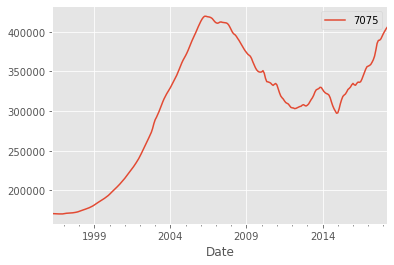

In [27]:
ts = ts_df[zipcode].copy()
ax = ts.plot()
ax.legend()
plt.show()

In [28]:
def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3, figsize=figsize)
    
    ts.plot(ax=ax[0])
    
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    fig.tight_layout()
    
    fig.suptitle(f"Zipcode: {ts.name}",y=1.1,fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig,ax

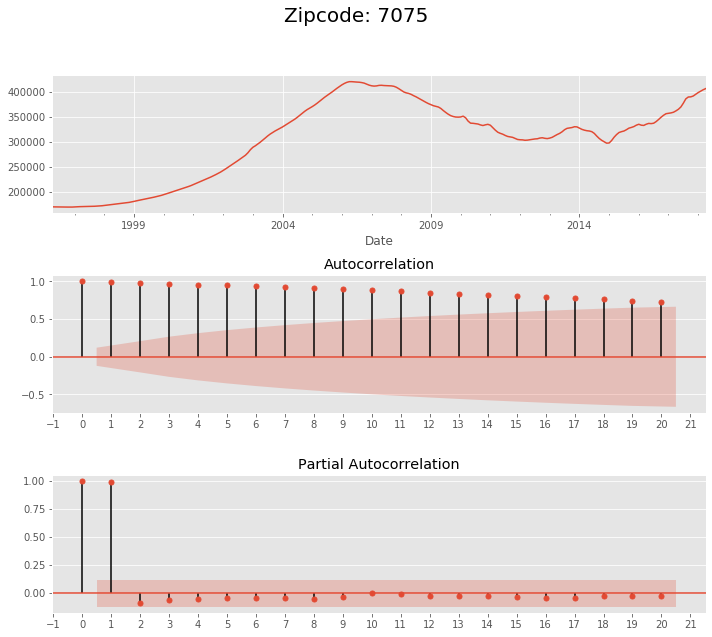

In [29]:
plot_acf_pacf(ts,lags=20);

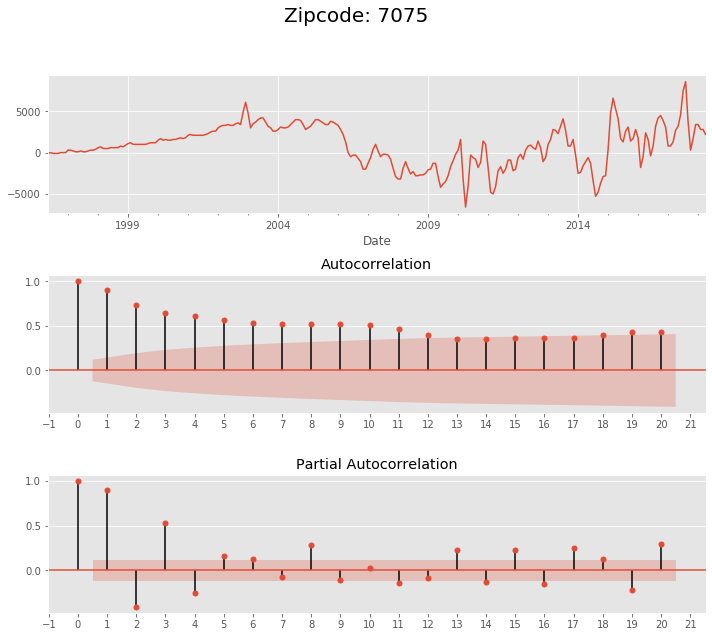

In [30]:
d = 1
plot_acf_pacf(ts.diff(d).dropna(),lags=20);

There is somewhat of a tail in both the ACF and PCF plots. Next, let's check for seasonality.

In [31]:
def seasonal_plots(df,N=13,lags=[12,24,36,48,60,72]):
    #Differencing the rolling mean to find seasonality in the resulting acf plot.
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = ts - ts.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();

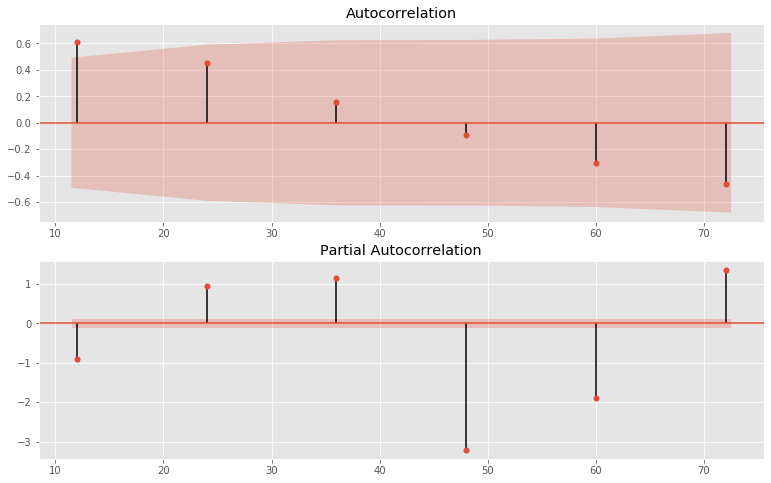

In [32]:
seasonal_plots(ts, N=13)

There are some peaks at 12 month intervals, but none at others. It is unclear whether or not there is seasonality. Let's continue to our first model.

In [33]:
# selected params
d = 1
p = 1
q = 1

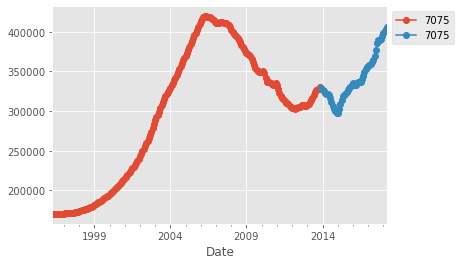

In [34]:
train_size = 0.8
split_idx = round(len(ts)* train_size)
split_idx

## Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

## Visualize split
fig,ax= plt.subplots()
kws = dict(ax=ax,marker='o')
train.plot(**kws)
test.plot(**kws)
ax.legend(bbox_to_anchor=[1,1])
plt.show()

In [35]:
len(test)

53

### Model 1

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7075   No. Observations:                  212
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1903.446
Date:                Tue, 20 Apr 2021   AIC                           3812.892
Time:                        22:25:00   BIC                           3822.948
Sample:                    04-01-1996   HQIC                          3816.957
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9663      0.012     80.552      0.000       0.943       0.990
ma.L1         -0.9437      0.015    -63.561      0.000      -0.973      -0.915
sigma2      3.768e+06   3.67e-11   1.03e+17      0.000    3.77e+06    3.77e+06
===================================================================================
Ljung-Box (Q):                     1511.15   Jarque-Bera (JB):                 7.04
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               1.79   Skew:                            -0.36
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.19e+33. Standard errors may be unstable.
"""

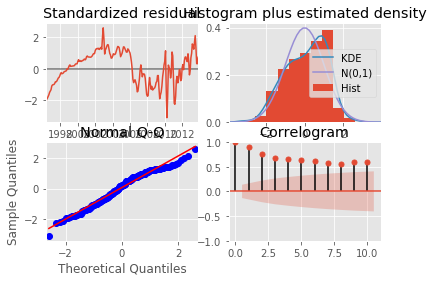

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Baseline model from eye-balled params
model = SARIMAX(train,order=(p,d,q),).fit()
display(model.summary())
model.plot_diagnostics();
plt.show()

In [37]:
## obtaining forecast
from sklearn import metrics
forecast = model.get_forecast(steps=len(test))

In [38]:
def forecast_to_df(forecast,zipcode):
    test_pred = forecast.conf_int()
    test_pred[zipcode] = forecast.predicted_mean
    test_pred.columns = ['lower','upper','prediction']
    return test_pred

pred_df = forecast_to_df(forecast,zipcode)

In [39]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['prediction'],label='prediction',ls='--',**kws)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'])
    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout()
    return fig,ax

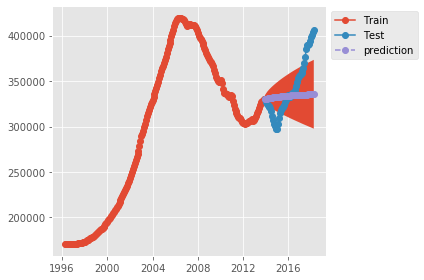

In [40]:
plot_train_test_pred(train,test,pred_df)

plt.show()

As we can see, the Q-Q plot looks good, but there is still too much noise in the residuals graph, not all of the data in the histogram fits under the curve, and there is still a slight tail in the correlogram. The path is also quite different in the test and train paths. Let's try a model using auto_arima to see if we can improve it.

### Model 2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  212
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1711.521
Date:                Tue, 20 Apr 2021   AIC                           3425.042
Time:                        22:25:02   BIC                           3428.389
Sample:                             0   HQIC                          3426.395
                                - 212                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.975e+05   2.92e+04     23.867      0.000     6.4e+05    7.55e+05
===================================================================================
Ljung-Box (Q):                      200.88   Jarque-Bera (JB):               699.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             110.79   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

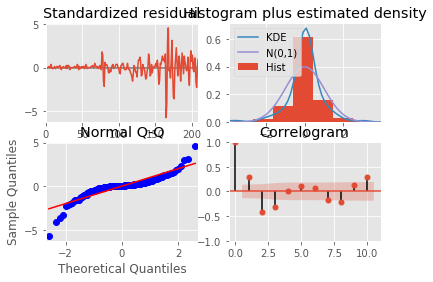

In [41]:
auto_model = auto_arima(train,start_p=0,start_q=0)
display(auto_model.summary())
auto_model.plot_diagnostics();

The other charts are better, but the Q-Q plot looks worse. Let's try using SARIMAX on the auto model find the best fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7075   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2213.319
Date:                Tue, 20 Apr 2021   AIC                           4428.638
Time:                        22:25:02   BIC                           4432.210
Sample:                    04-01-1996   HQIC                          4430.074
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.186e+06   5.54e+04     21.401      0.000    1.08e+06    1.29e+06
===================================================================================
Ljung-Box (Q):                      175.50   Jarque-Bera (JB):               274.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              19.81   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

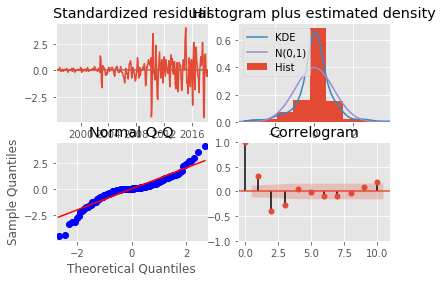

In [42]:
model3 = SARIMAX(ts,order=auto_model.order,
                     seasonal_order=auto_model.seasonal_order).fit()
display(model3.summary())
model3.plot_diagnostics();

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c775128748>)

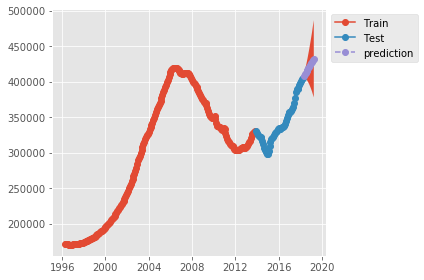

In [43]:
pred = model3.get_forecast(steps=12)#start=test.index[0],end=test.index[-1])
pred_df = forecast_to_df(pred,zipcode)
display(plot_train_test_pred(train,test,pred_df));
plt.show()

The Q-Q plot still doesn't look the best, but that's okay. The other charts still look good and the train, test, and prediction paths all match up.

Clearly, the SARIMAX model works the best. Instead of repeating this process eleven more times, let's create a for loop that will execute the SARIMAX model on the remaining zip codes and give the best fit.

### Looping Model 3

7075


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7075   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2213.319
Date:                Tue, 20 Apr 2021   AIC                           4428.638
Time:                        22:25:03   BIC                           4432.210
Sample:                    04-01-1996   HQIC                          4430.074
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.186e+06   5.54e+04     21.401      0.000    1.08e+06    1.29e+06
===================================================================================
Ljung-Box (Q):                      175.50   Jarque-Bera (JB):               274.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              19.81   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

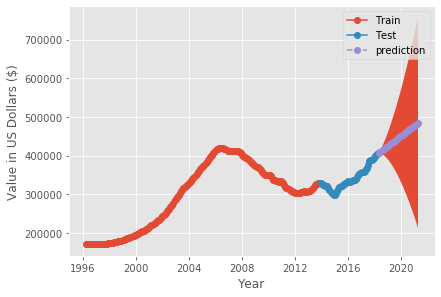

------------------------------------------------------------

7747


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7747   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2058.212
Date:                Tue, 20 Apr 2021   AIC                           4120.423
Time:                        22:25:04   BIC                           4127.568
Sample:                    04-01-1996   HQIC                          4123.294
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0323      0.009      3.667      0.000       0.015       0.050
sigma2      3.606e+05   2.09e+04     17.260      0.000     3.2e+05    4.02e+05
===================================================================================
Ljung-Box (Q):                      153.68   Jarque-Bera (JB):                69.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              20.60   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

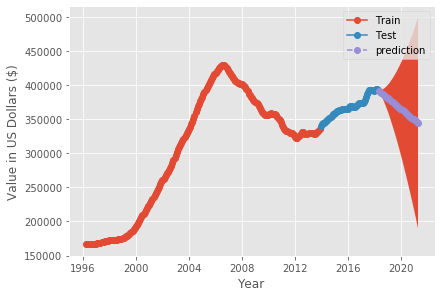

------------------------------------------------------------

7066


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7066   No. Observations:                  265
Model:               SARIMAX(1, 2, 0)   Log Likelihood               -2170.199
Date:                Tue, 20 Apr 2021   AIC                           4344.398
Time:                        22:25:05   BIC                           4351.542
Sample:                    04-01-1996   HQIC                          4347.269
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0213      0.009      2.433      0.015       0.004       0.039
sigma2      8.525e+05   5.05e+04     16.897      0.000    7.54e+05    9.51e+05
===================================================================================
Ljung-Box (Q):                      233.64   Jarque-Bera (JB):                63.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              21.15   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

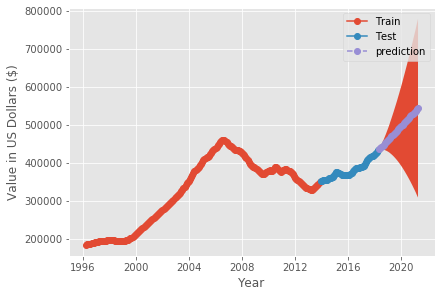

------------------------------------------------------------

8527


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   8527   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2044.480
Date:                Tue, 20 Apr 2021   AIC                           4090.961
Time:                        22:25:06   BIC                           4094.533
Sample:                    04-01-1996   HQIC                          4092.396
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.295e+05   1.88e+04     17.535      0.000    2.93e+05    3.66e+05
===================================================================================
Ljung-Box (Q):                      285.03   Jarque-Bera (JB):                82.50
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              20.59   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

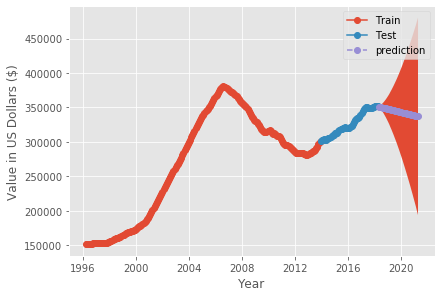

------------------------------------------------------------

7724


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7724   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2123.664
Date:                Tue, 20 Apr 2021   AIC                           4249.328
Time:                        22:25:07   BIC                           4252.900
Sample:                    04-01-1996   HQIC                          4250.764
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.996e+05    2.9e+04     20.644      0.000    5.43e+05    6.57e+05
===================================================================================
Ljung-Box (Q):                      135.17   Jarque-Bera (JB):               214.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              31.71   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

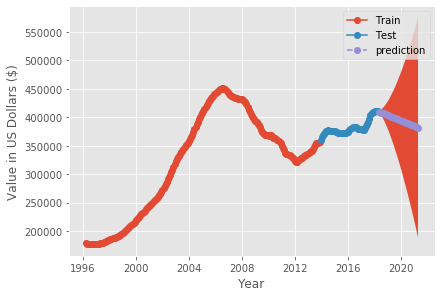

------------------------------------------------------------

8230


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   8230   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2145.449
Date:                Tue, 20 Apr 2021   AIC                           4294.898
Time:                        22:25:08   BIC                           4302.042
Sample:                    04-01-1996   HQIC                          4297.769
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0372      0.009      4.064      0.000       0.019       0.055
sigma2       7.01e+05   3.87e+04     18.128      0.000    6.25e+05    7.77e+05
===================================================================================
Ljung-Box (Q):                      202.00   Jarque-Bera (JB):                99.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              25.76   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

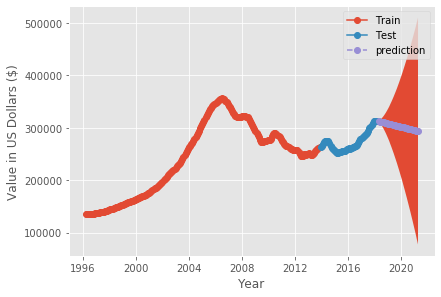

------------------------------------------------------------

7731


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7731   No. Observations:                  265
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -2026.532
Date:                Tue, 20 Apr 2021   AIC                           4057.063
Time:                        22:25:09   BIC                           4064.208
Sample:                    04-01-1996   HQIC                          4059.935
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0344      0.009      3.747      0.000       0.016       0.052
sigma2       2.83e+05   1.63e+04     17.345      0.000    2.51e+05    3.15e+05
===================================================================================
Ljung-Box (Q):                      138.22   Jarque-Bera (JB):                72.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.04   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

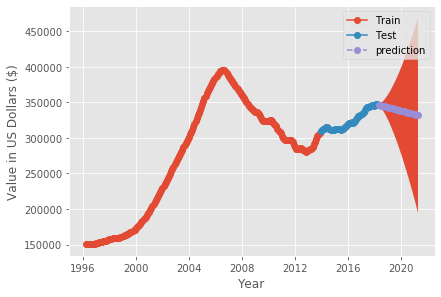

------------------------------------------------------------

7748


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7748   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2132.451
Date:                Tue, 20 Apr 2021   AIC                           4266.901
Time:                        22:25:09   BIC                           4270.473
Sample:                    04-01-1996   HQIC                          4268.337
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.411e+05   3.74e+04     17.133      0.000    5.68e+05    7.14e+05
===================================================================================
Ljung-Box (Q):                      268.94   Jarque-Bera (JB):                63.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              43.90   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

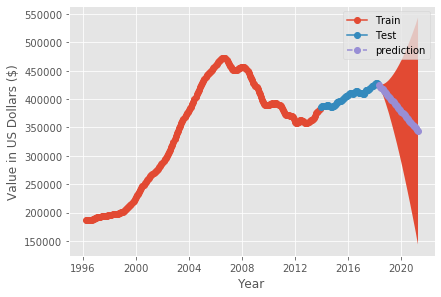

------------------------------------------------------------

7410


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7410   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2114.308
Date:                Tue, 20 Apr 2021   AIC                           4230.617
Time:                        22:25:10   BIC                           4234.189
Sample:                    04-01-1996   HQIC                          4232.052
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.599e+05   2.83e+04     19.789      0.000    5.04e+05    6.15e+05
===================================================================================
Ljung-Box (Q):                      178.42   Jarque-Bera (JB):               171.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              39.74   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

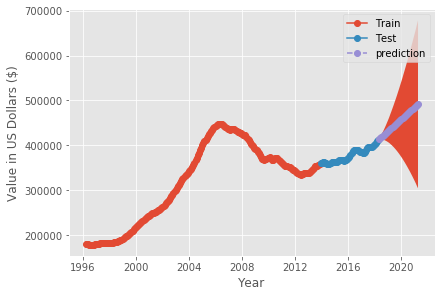

------------------------------------------------------------

8824


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   8824   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2249.968
Date:                Tue, 20 Apr 2021   AIC                           4501.936
Time:                        22:25:10   BIC                           4505.508
Sample:                    04-01-1996   HQIC                          4503.372
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.567e+06   9.82e+04     15.953      0.000    1.37e+06    1.76e+06
===================================================================================
Ljung-Box (Q):                      154.20   Jarque-Bera (JB):                36.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             110.99   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

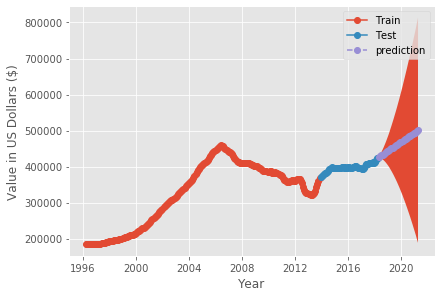

------------------------------------------------------------

7604


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7604   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2143.029
Date:                Tue, 20 Apr 2021   AIC                           4288.057
Time:                        22:25:11   BIC                           4291.629
Sample:                    04-01-1996   HQIC                          4289.493
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.948e+05   3.61e+04     19.249      0.000    6.24e+05    7.65e+05
===================================================================================
Ljung-Box (Q):                      150.24   Jarque-Bera (JB):               140.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              19.28   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

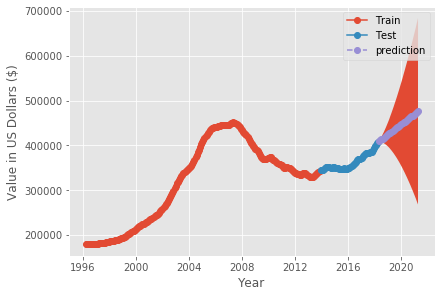

------------------------------------------------------------

7621


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   7621   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2121.419
Date:                Tue, 20 Apr 2021   AIC                           4244.838
Time:                        22:25:12   BIC                           4248.410
Sample:                    04-01-1996   HQIC                          4246.273
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.895e+05   2.78e+04     21.238      0.000    5.35e+05    6.44e+05
===================================================================================
Ljung-Box (Q):                      207.51   Jarque-Bera (JB):               250.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              76.07   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

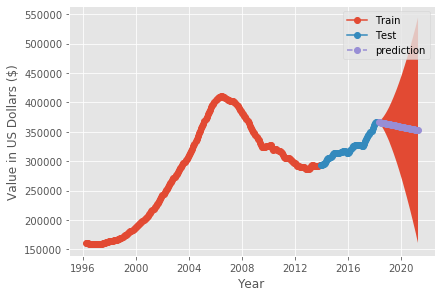

------------------------------------------------------------



In [44]:
RESULTS = {}

for zc in zip_list:
    print(zc)
    
    ## Make empty dict for district data
    zipcode_d = {}
    
    ## Copy Time Series
    ts_final = ts_df[zc].copy()
    
    ## Train Test Split Index
    train_size = 0.8
    split_idx = round(len(ts)* train_size)

    ## Split
    train = ts_final.iloc[:split_idx]
    test = ts_final.iloc[split_idx:]
    
    
    ## Get best params using auto_arima
    gridsearch_model = auto_arima(ts_final,start_p=0,start_q=0)
    model3 = SARIMAX(ts_final,order=gridsearch_model.order,
                     seasonal_order=gridsearch_model.seasonal_order).fit()
    
    ## Get predictions
    pred  = model3.get_forecast(steps=36)#start=test.index[0],end=test.index[-1])
    pred_df = forecast_to_df(pred,zipcode)

    ## Save info to dict
    zipcode_d['pred_df'] = pred_df
    zipcode_d['model'] = model3
    zipcode_d['train'] = train
    zipcode_d['test'] = test
    
    ## Display Results
    display(model3.summary())
    plot_train_test_pred(train,test,pred_df)
    plt.xlabel('Year')
    plt.ylabel('Value in US Dollars ($)')
    plt.savefig('images/' + zc + 'prediction' + '.png')
    plt.show()
    
    
    ## Save district dict in RESULTS
    RESULTS[zc] = zipcode_d
    print('---'*20,end='\n\n')

From the predictions, we can see that the best zip codes are 07075, 07066, 07410, 08824, and 07604. Let's check for stationarity and measure their future returns.

In [45]:
zip_7075 = melted_df[melted_df.ZipCode == '7075']
zip_7066 = melted_df[melted_df.ZipCode == '7066']
zip_7410 = melted_df[melted_df.ZipCode == '7410']
zip_8824 = melted_df[melted_df.ZipCode == '8824']
zip_7604 = melted_df[melted_df.ZipCode == '7604']

In [46]:
zip_df = pd.DataFrame()
zip_df = zip_df.append(zip_7075)
zip_df = zip_df.append(zip_7066)
zip_df = zip_df.append(zip_7410)
zip_df = zip_df.append(zip_8824)
zip_df = zip_df.append(zip_7604)
zip_df.head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,7075,Wood Ridge,NJ,New York,Bergen,170700.0
1996-05-01,7075,Wood Ridge,NJ,New York,Bergen,170600.0
1996-06-01,7075,Wood Ridge,NJ,New York,Bergen,170600.0
1996-07-01,7075,Wood Ridge,NJ,New York,Bergen,170500.0
1996-08-01,7075,Wood Ridge,NJ,New York,Bergen,170400.0


In [47]:
zip_ts = []
for zc in zip_df.ZipCode.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = zip_df[zip_df['ZipCode']==zc].asfreq('MS')
    zip_ts.append(df)
zip_ts[0].head()

,ZipCode,City,State,Metro,CountyName,value
Date,,,,,,
1996-04-01,7075,Wood Ridge,NJ,New York,Bergen,170700.0
1996-05-01,7075,Wood Ridge,NJ,New York,Bergen,170600.0
1996-06-01,7075,Wood Ridge,NJ,New York,Bergen,170600.0
1996-07-01,7075,Wood Ridge,NJ,New York,Bergen,170500.0
1996-08-01,7075,Wood Ridge,NJ,New York,Bergen,170400.0


In [48]:
for i in range(len(zip_ts)):
    print(f'Value descriptive statistics for zipcode {zip_ts[i].ZipCode[0]}:')
    print(f'{zip_ts[i].value.describe()}\n')

Value descriptive statistics for zipcode 7075:
count       265.000000
mean     305414.339623
std       78476.429233
min      170300.000000
25%      234800.000000
50%      321600.000000
75%      364200.000000
max      419600.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 7066:
count       265.000000
mean     335047.924528
std       82753.010138
min      184800.000000
25%      267500.000000
50%      367100.000000
75%      388900.000000
max      460200.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 7410:
count       265.000000
mean     330435.849057
std       83023.752749
min      179500.000000
25%      257200.000000
50%      359000.000000
75%      389500.000000
max      447900.000000
Name: value, dtype: float64

Value descriptive statistics for zipcode 8824:
count       265.000000
mean     339229.811321
std       83821.199371
min      184000.000000
25%      272700.000000
50%      372400.000000
75%      399900.000000
max      458

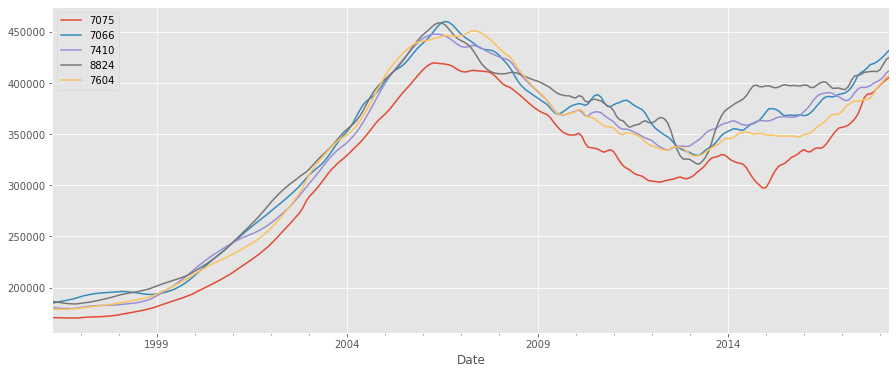

In [49]:
for i in range(5):
    zip_ts[i].value.plot(label=zip_ts[i].ZipCode[0],figsize=(15,6))
    plt.savefig('images/top5zip.png', dpi=300)
    plt.legend()

In [50]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(zip_ts)):
    zip_ts[zc]['ret']=np.nan*len(zip_ts[zc])
    for i in range(len(zip_ts[zc])-1):
        zip_ts[zc]['ret'][i+1]= (zip_ts[zc].value.iloc[i+1] / zip_ts[zc].value.iloc[i]) - 1

In [51]:
for i in range(5):
    results = adfuller(zip_ts[i].ret.dropna())
    print(f'ADFuller test p-value for zipcode: {zip_ts[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Accept the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 7075
p-value: 0.521553027855205
Accept the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 7066
p-value: 0.23563149019639212
Accept the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 7410
p-value: 0.38111400835405007
Accept the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 8824
p-value: 0.2521332795322828
Accept the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 7604
p-value: 0.44995220496157706
Accept the null hypothesis. Data is not stationary.



In [52]:
for i in [0,1,2,3,4]:
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(zip_ts[i].ret.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {zip_ts[i].ZipCode[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Accpet the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 7075
p-value: 2.7894580845450036e-08
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 7066
p-value: 3.2392624102317023e-06
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 7410
p-value: 3.054886113570672e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 8824
p-value: 3.5162585321235576e-08
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 7604
p-value: 1.5097574724672082e-05
Reject the null hypothesis. Data is stationary.



In [53]:
#Create individual time series for each of the positive zipcodes
TS_7075 = zip_ts[0].ret.dropna()
TS_7075d = zip_ts[0].ret.diff().dropna()

TS_7066 = zip_ts[1].ret.dropna()
TS_7066d = zip_ts[1].ret.diff().dropna()

TS_7410 = zip_ts[2].ret.dropna()
TS_7410d = zip_ts[2].ret.diff().dropna()

TS_8824 = zip_ts[3].ret.dropna()
TS_8824d = zip_ts[3].ret.diff().dropna()

TS_7604 = zip_ts[4].ret.dropna()
TS_7604d = zip_ts[4].ret.diff().dropna()

In [54]:
def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3, figsize=figsize)
    
    ts.plot(ax=ax[0])
    
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    fig.tight_layout()
    
#    fig.suptitle(f"Zipcode: {ts.name}",y=1.1,fontsize=20)
    
    for a in ax[1:]:
        a.xaxis.set_major_locator(mpl.ticker.MaxNLocator(min_n_ticks=lags, integer=True))
        a.xaxis.grid()
    return fig,ax

def seasonal_plots(df,N=13,lags=[12,24,36,48,60,72]):
    #Differencing the rolling mean to find seasonality in the resulting acf plot.
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = ts - ts.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();

def model_fit(df,pdq=(1,0,1),pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

def forecast_model(df,pdq=(1,0,1),pdqs=(0,0,0,1), display=True,zc='input zipcode'):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

### Zip Code 07075

(<Figure size 720x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C77254C3C8>,
       dtype=object))

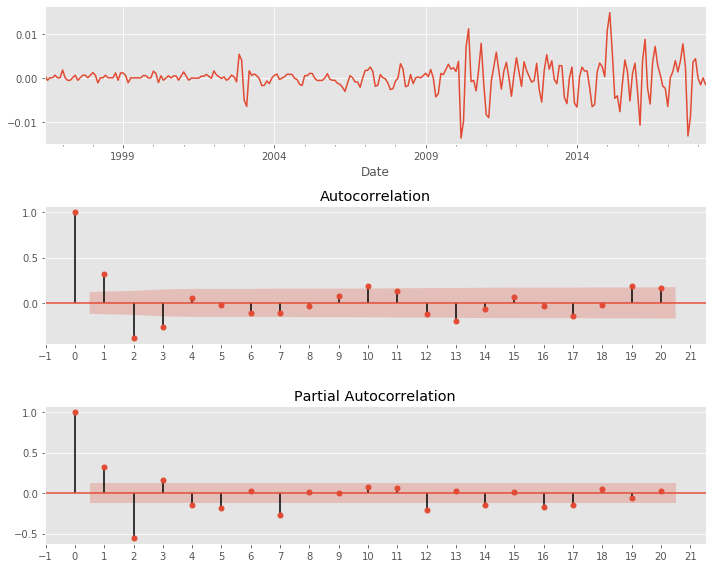

In [55]:
plot_acf_pacf(TS_7075d,lags=20)

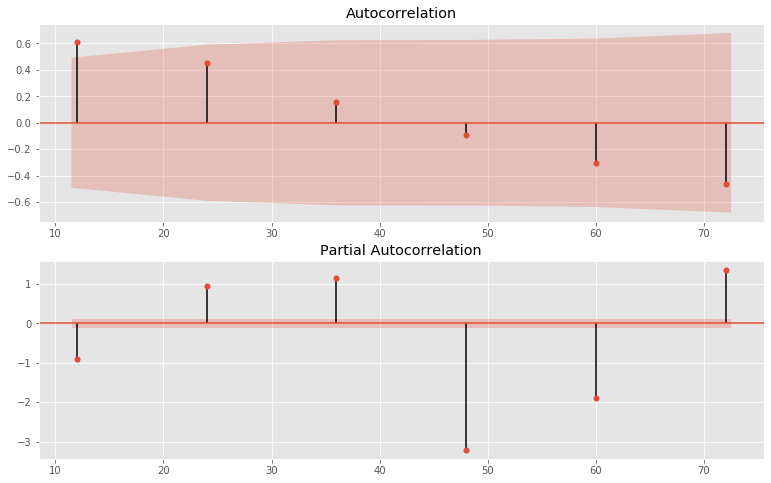

In [56]:
seasonal_plots(TS_7075d, N=13)

In [57]:
results = pm.auto_arima(TS_7075,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2374.677, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1830.833, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2280.060, Time=0.47 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2147.567, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1785.686, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2371.566, Time=0.48 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2283.060, Time=0.25 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-2371.465, Time=2.10 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2371.460, Time=1.56 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2372.704, Time=0.34 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2373.109, Time=1.32 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-2373.069, Time=1.96 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-2375.068, Time=2.95 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-2157.706, Time=2.23 sec
 ARIM

ARIMA(order=(1, 0, 3), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

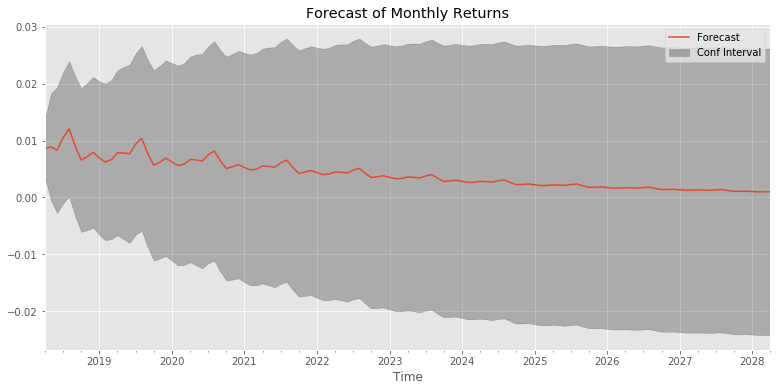

Total expected return in 1 year: 10.35%
Total expected return in 3 years: 29.49%
Total expected return in 5 year: 44.32%
Total expected return in 10 years: 63.68%


In [58]:
pdq = (1, 0, 3)
pdqs = (2, 0, 2, 12)
ret_7075 = forecast_model(TS_7075,pdq=pdq,pdqs=pdqs,zc=7075)

### Zip Code 07066

(<Figure size 720x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7752654E0>,
       dtype=object))

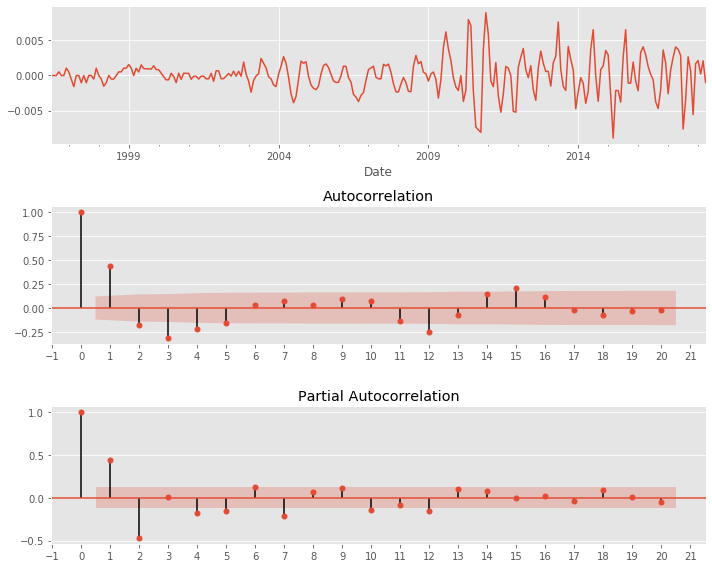

In [59]:
plot_acf_pacf(TS_7066d,lags=20)

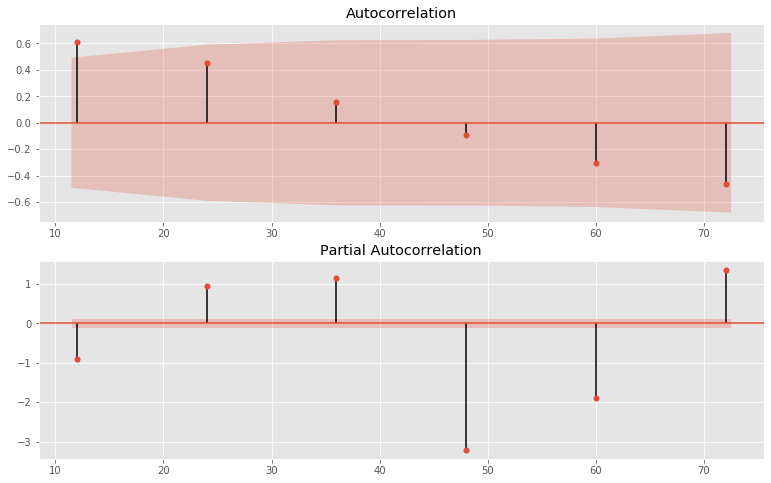

In [60]:
seasonal_plots(TS_7066d, N=13)

In [61]:
results = pm.auto_arima(TS_7066,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2528.749, Time=0.46 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1872.553, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2299.343, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2214.622, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1822.015, Time=0.03 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2527.776, Time=0.59 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2523.988, Time=0.47 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-2534.470, Time=1.96 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-2526.669, Time=2.64 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-2536.265, Time=2.72 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2520.742, Time=2.15 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-2213.047, Time=1.96 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-2458.656, Time=1.70 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=-2509.893, Time=3.19 sec
 ARIM

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

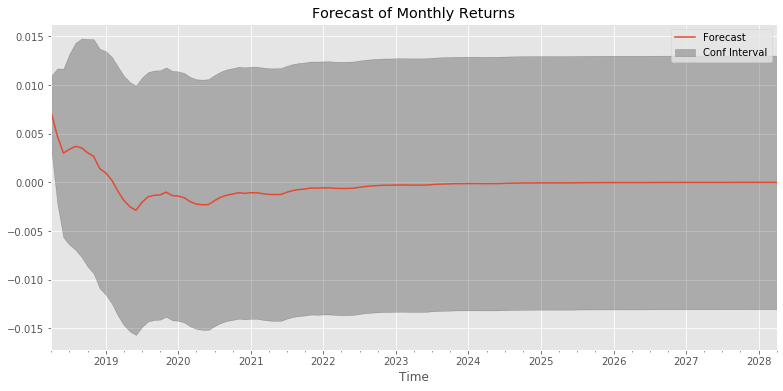

Total expected return in 1 year: 3.35%
Total expected return in 3 years: -0.61%
Total expected return in 5 year: -2.08%
Total expected return in 10 years: -2.47%


In [62]:
pdq = (1, 0, 1)
pdqs = (2, 0, 2, 12)
ret_7066 = forecast_model(TS_7066,pdq=pdq,pdqs=pdqs,zc=7066)

### Zip Code 07410

(<Figure size 720x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7744A65C0>,
       dtype=object))

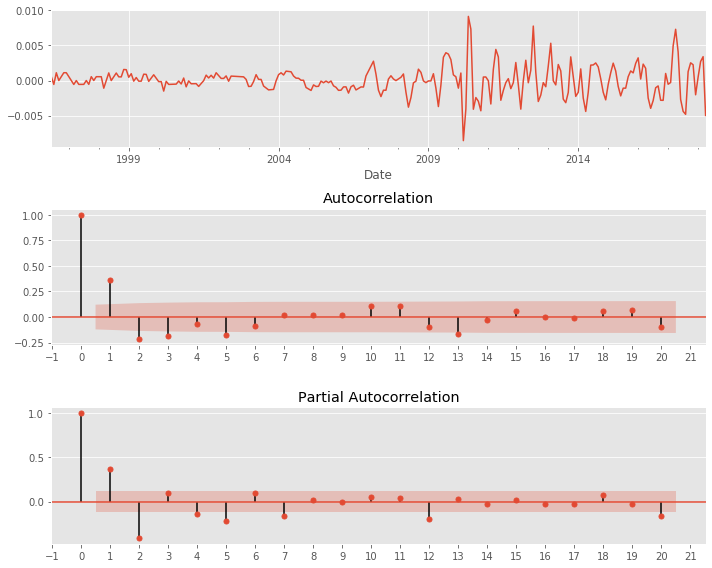

In [63]:
plot_acf_pacf(TS_7410d,lags=20)

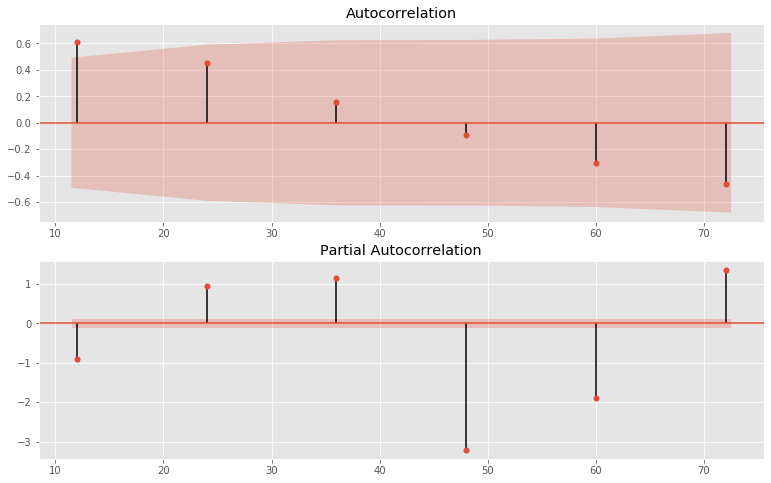

In [64]:
seasonal_plots(TS_7410d, N=13)

In [65]:
results = pm.auto_arima(TS_7066,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2528.749, Time=0.56 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1872.553, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2299.343, Time=0.37 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2214.622, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1822.015, Time=0.03 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2527.776, Time=0.80 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2523.988, Time=0.59 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-2534.470, Time=2.33 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-2526.669, Time=2.90 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=-2536.265, Time=2.99 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2520.742, Time=2.41 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=-2213.047, Time=2.18 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=-2458.656, Time=1.90 sec
 ARIMA(2,0,1)(2,0,2)[12] intercept   : AIC=-2509.893, Time=4.14 sec
 ARIM

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

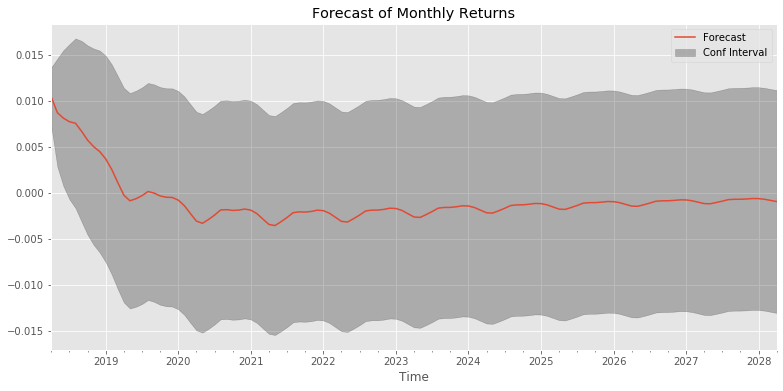

Total expected return in 1 year: 7.38%
Total expected return in 3 years: 3.54%
Total expected return in 5 year: -2.22%
Total expected return in 10 years: -9.8%


In [66]:
pdq = (1, 0, 1)
pdqs = (2, 0, 2, 12)
ret_7410 = forecast_model(TS_7410,pdq=pdq,pdqs=pdqs,zc=7410)

### Zip Code 08824

(<Figure size 720x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7743856A0>,
       dtype=object))

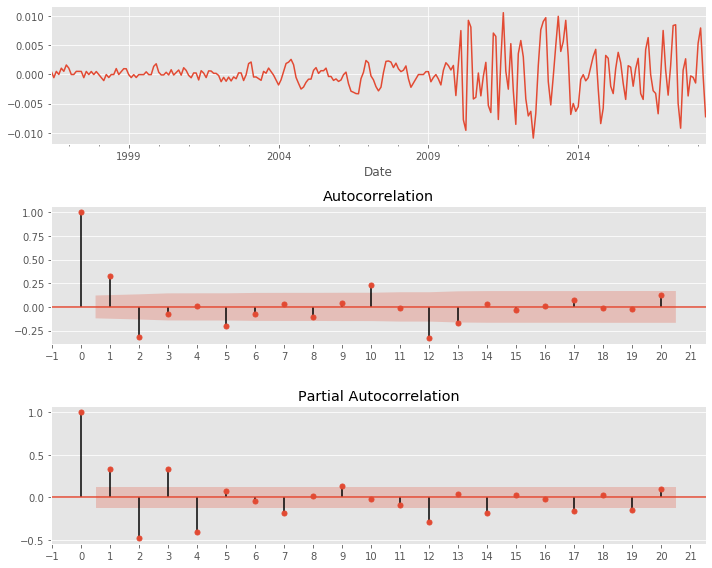

In [67]:
plot_acf_pacf(TS_8824d,lags=20)

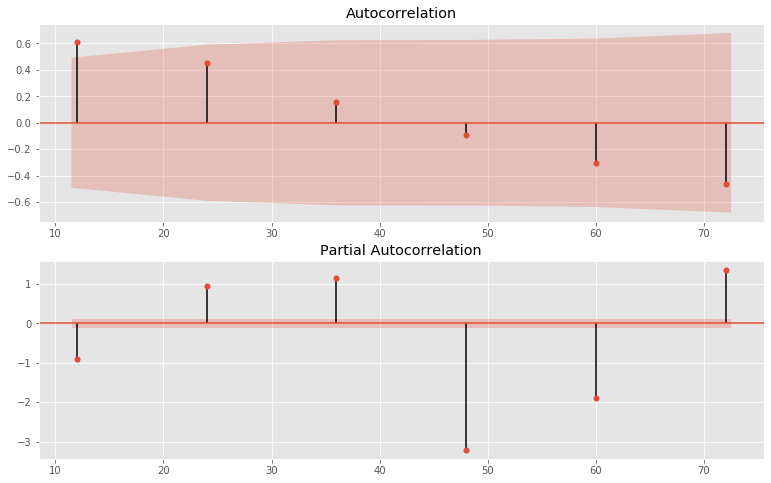

In [68]:
seasonal_plots(TS_8824d, N=13)

In [69]:
results = pm.auto_arima(TS_8824,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2404.232, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1815.936, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2287.908, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1776.991, Time=0.03 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2430.751, Time=0.78 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2401.604, Time=0.37 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2441.984, Time=2.17 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2421.594, Time=2.57 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-2142.664, Time=1.76 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=-2305.006, Time=1.23 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=-2431.653, Time=2.31 sec
 ARIMA(1,0,2)(0,0,2)[12] intercept   : AIC=-2438.958, Time=2.49 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-1825.921, Time=0.90 sec
 ARIMA(0,0,

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

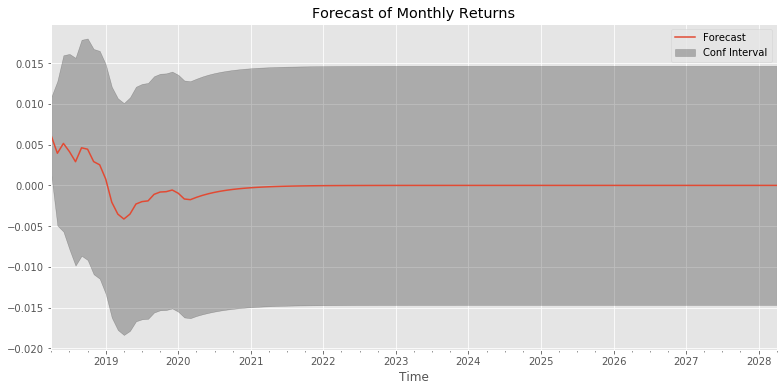

Total expected return in 1 year: 3.23%
Total expected return in 3 years: 0.25%
Total expected return in 5 year: 0.15%
Total expected return in 10 years: 0.14%


In [70]:
pdq = (1, 0, 1)
pdqs = (0, 0, 2, 12)
ret_8824 = forecast_model(TS_8824,pdq=pdq,pdqs=pdqs,zc=8824)

### Zip Code 07604

(<Figure size 720x576 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C7007EACC0>,
       dtype=object))

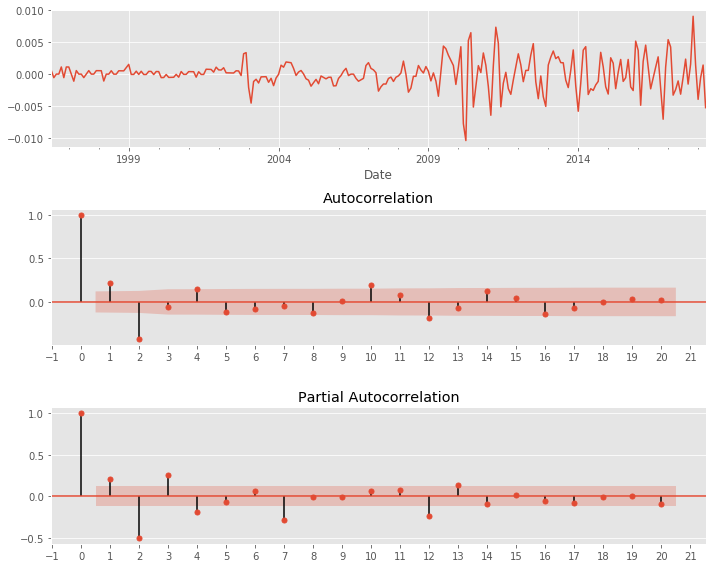

In [71]:
plot_acf_pacf(TS_7604d,lags=20)

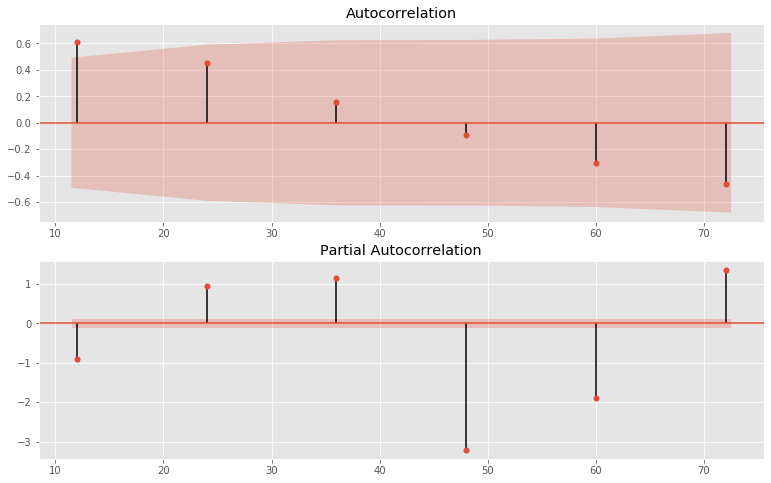

In [72]:
seasonal_plots(TS_7604d, N=13)

In [73]:
results = pm.auto_arima(TS_7604,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-2549.341, Time=1.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1897.679, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-2460.660, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-2264.796, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1845.576, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-2537.501, Time=0.59 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-2521.381, Time=0.68 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-2543.661, Time=2.07 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=-2539.840, Time=1.71 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-2526.432, Time=0.26 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-2540.061, Time=1.61 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-2380.016, Time=1.59 sec
 ARIMA(1,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-2296.249, Time=0.69 sec
 ARIMA(1,0,

ARIMA(order=(1, 0, 1), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True)

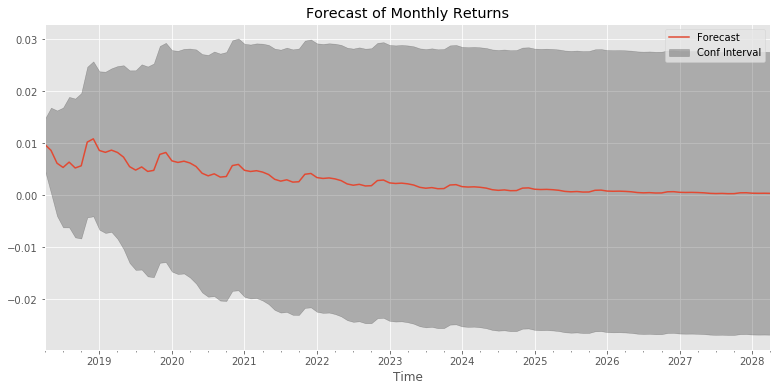

Total expected return in 1 year: 9.78%
Total expected return in 3 years: 25.31%
Total expected return in 5 year: 34.2%
Total expected return in 10 years: 41.68%


In [74]:
pdq = (1, 0, 1)
pdqs = (1, 0, 1, 12)
ret_8824 = forecast_model(TS_7604,pdq=pdq,pdqs=pdqs,zc=8824)

## Step 5: Interpreting Results

From our model's predicitions, we can easily see that 07075, 07066, 07410, 08824, and 07604 are the top 5 zip codes to invest in. The expected returns show that it's better to buy, flip and sell homes in 1 to 3 years in 07066, 07410, and 08824, while longer home renovations and later sales could be more beneficial and lead to higher returns in 07075 and 07604.